## Questions for AIHUB

In [25]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

Consider these a list of questions that will allow you to prepare for the GEC Summer AI-Hub session (or to generally further your understanding of machine learning).  While we won't grade your answers to the questions we will provide solutions so that you can check your own understanding.  You will get the most reward if you look at the answers only after making a substantial effort to try to solve these questions on your own first.

<hr style="height:2pt">

![wine quality](https://ec.europa.eu/info/sites/info/files/food-farming-fisheries/news/images/istock-516799356.jpg)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>

### Overview 

From [Science Direct](https://www.sciencedirect.com/topics/food-science/wine-quality)

> Wine quality, as Maynard Amerine once said, is easier to detect than define. This is partially due to quality being primarily subjective, and strongly influenced by extrinsic factors. Correspondingly, defining wine quality in terms of its chemistry will never be more than partially successful. 
>
>Nonetheless, most serious wine connoisseurs tend to agree on what constitutes wine quality, that is, what they subjectively have come to like through extensive tasting. Although disappointingly nebulous, it has still been sufficient to guide grape growers and winemakers in their choice of the procedures they use. What is not certain is if this is a complex example of the blind leading the blind. 
>
>This disturbing thought is partially supported by the unquestioning acceptance of certain traditions concerning grape and wine production, notably ideas about small berries, old vines, limited yield, avoidance of irrigation, etc., as being critical to wine quality.

Assume that you are are hired by the renown wine magazine [Somm Journal](https://www.sommjournal.com/) to **help them predict quality of portuguese regional wines based upon a number of chemical attributes -- including density, acidity, alcohol content**.  Quality is an ordinal rank from 1 (worst) to 10 (best) of the variety of the wine as judged by three independent tasters. The final rank assigned is the median rank given by the tasters.

### Use only the libraries below:

In [104]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set can be obtained from the UCI Machine Learning Repository at the urls `http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv` and `http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv`. Each row in these file represents measurements of the chemical properties of a white or red wine variant of the Portuguese "Vinho Verde" wine. 

The 12 attributes are as follows:


-   `quality`
-   `fixed acidity`
-   `volatile acidity`
-   `citric acid`
-   `residual sugar`
-   `chlorides`
-   `free sulfur dioxide`
-   `total sulfur dioxide`
-   `density`
-   `pH`
-   `sulphates`
-   `alcohol`

Use `quality` as the response variable.

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1 [10pts]: Data Read-In, Cleaning and Preprocessing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the wine quality dataset from the csv files given in the UCI ML links into a pandas dataframe that you name `wine_data`.  Make sure to merge the data in the csvs into one data frame and add one additional binary feature called color that is 1 if the wine is red and 0 if it's white.

**1.2** Do the data types make sense?  Calculate the **Inter-Quartile Range (IQR)** for each feature.  The IQR can be calculated by subtracting the 25th percentile from the 75th percentile.  Let's call a data point an **upper outlier** for a particular feature if its value for that feature is > the mean of that feature + 1.5 * IQR.  Similarly a data point is a **lower outlier** for a feature if its value for that feature is < the mean of that feature - 1.5 * IQR.  Which features have outliers (upper or lower)?  Create a table showing how many upper and lower outliers there are for each feature.

**1.3** Split the updated `wine_data` dataset into a training set and test set. Use a `StandardScaler` from `sklearn.preprocessing` to standarize your data

### Answers

#### **1.1** Load the wine quality dataset from the csv files given in the UCI ML links into a pandas dataframe that you name `wine_data`.  Make sure to merge the data in the csvs into one data frame and add one additional binary feature called color that is 1 if the wine is red and 0 if it's white.


In [27]:
# your code here

dataset_url1 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
dataset_url2 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# read wine data
red_wine_data = pd.read_csv(dataset_url1, sep=';')
white_wine_data = pd.read_csv(dataset_url2, sep=';')

red_wine_data['wine_color'] = 1   # feature for the wine color
white_wine_data['wine_color'] = 0  # feature for the wine color

wine_data = pd.concat([red_wine_data, white_wine_data])

print(wine_data.info())
wine_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
wine_color              6497 non-null int64
dtypes: float64(11), int64(2)
memory usage: 710.6 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [28]:
# your code here
describe_stats = wine_data.describe()

describe_stats

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_color
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.246114
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,0.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,0.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


#### **1.2** Do the data types make sense?  Calculate the **Inter-Quartile Range (IQR)** for each feature.  The IQR can be calculated by subtracting the 25th percentile from the 75th percentile.  Let's call a data point an **upper outlier** for a particular feature if its value for that feature is > the mean of that feature + 1.5 * IQR.  Similarly a data point is a **lower outlier** for a feature if its value for that feature is < the mean of that feature - 1.5 * IQR.  Which features have outliers (upper or lower)?  Create a table showing how many upper and lower outliers there are for each feature.

In [29]:
# your code here

limits_upper, limits_lower = [], []
outliers_upper, outliers_lower = [], []
num_upper, num_lower = [], []

#loop through features - get data on outliers
for idx, column in enumerate(describe_stats.columns):
    
    if (column == 'quality' or column == 'wine_color'):
        continue
    
    # find IQR 
    # 75th percentile is in 6th row of describe
    # 25th percentile is in 4th row of describe
    iqr = describe_stats.iloc[6,idx] - describe_stats.iloc[4,idx]
    
    # find and save upper outlier limits (to determine upper outliers)
    limit_upper = describe_stats.iloc[6,idx] + 1.5 * iqr
    limits_upper.append(limit_upper)

    # grab all the upper outliers
    outliers_upper.append(wine_data.loc[wine_data[wine_data.columns[idx]] > limit_upper])
    
    # save the size of the set of upper outliers
    num_upper.append(len(outliers_upper[-1]))
        
    # find and save lower outlier limits
    limit_lower = describe_stats.iloc[4,idx] - 1.5 * iqr
    limits_lower.append(limit_lower)
    
    # grab all the lower outliers
    outliers_lower.append(wine_data.loc[wine_data[wine_data.columns[idx]] < limit_lower])
    
    # save the size of the set of lower outliers
    num_lower.append(len(outliers_lower[-1]))


In [30]:
feature_columns = wine_data.columns[:11]

wine_upper_outliers = pd.DataFrame(zip(feature_columns, limits_upper, num_upper), 
                         columns = ['Feature', 'Upper Limit', 'Upper Outliers'])
wine_upper_outliers

,Feature,Upper Limit,Upper Outliers
0,fixed acidity,9.650000,350
1,volatile acidity,0.655000,377
2,citric acid,0.600000,230
3,residual sugar,17.550000,118
4,chlorides,0.105500,286
5,free sulfur dioxide,77.000000,62
6,total sulfur dioxide,274.500000,10
7,density,1.003965,3
8,pH,3.635000,66
9,sulphates,0.855000,191


In [31]:
wine_lower_outliers = pd.DataFrame(zip(feature_columns, limits_lower, num_lower), 
                         columns = ['Feature', 'Lower Limit', 'Lower Outliers'])
wine_lower_outliers

,Feature,Lower Limit,Lower Outliers
0,fixed acidity,4.450000,7
1,volatile acidity,-0.025000,0
2,citric acid,0.040000,279
3,residual sugar,-7.650000,0
4,chlorides,-0.002500,0
5,free sulfur dioxide,-19.000000,0
6,total sulfur dioxide,-41.500000,0
7,density,0.985365,0
8,pH,2.795000,7
9,sulphates,0.175000,0


#### **1.3** Split the updated `wine_data` dataset into a training set and test set. Use a `StandardScaler` from `sklearn.preprocessing` to standarize your data

In [32]:
# your code here

#Separate target from training features
X = wine_data.drop('quality', axis=1)
y = wine_data.quality

# We stratify our sample to make sure 
# training and test sets look similar i.e.
# have the same number of red and white whines

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)

In [33]:
# Let's create a scaler to scale our training sets
scaler = preprocessing.StandardScaler().fit(X_train)

# Let's apply the scaler to our training set
X_train_scaled = scaler.transform(X_train)

# Let's apply the scaler to our test set
X_test_scaled = scaler.transform(X_test)

/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/igodo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/home/igodo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Visualize the histograms of each of the features. pandas's `hist` or seaborn's `kdeplot` functionality may come in handy here.

**2.2** Use pandas' `scatter_matrix` to visualize the inter-dependencies among all predictors in the dataset. [Be aware that this may take quite some time to run.]

**2.3** Explore in more detail potential correlations amongst the different features by leveraging a pair-wise correlation matrix and depicting it as a heatmap.  What are some features have relatively high positive or negative correlations?

**2.4** We merged the datasets for white and red wines.  It may be instructive to determine how the two wine types differ along various features.  Plot side-by-side distributions of the red and white wines for wine quality.  What does your visualization say about how the two types of wine differ?

**2.5** Repeat your visualization from **2.4** for another feature you'd expect the two types of wines to differ based on your correlation plot in **2.3**.

### Answers

#### **2.1** Visualize the histograms of each of the features. pandas's `hist` or seaborn's `kdeplot` functionality may come in handy here.

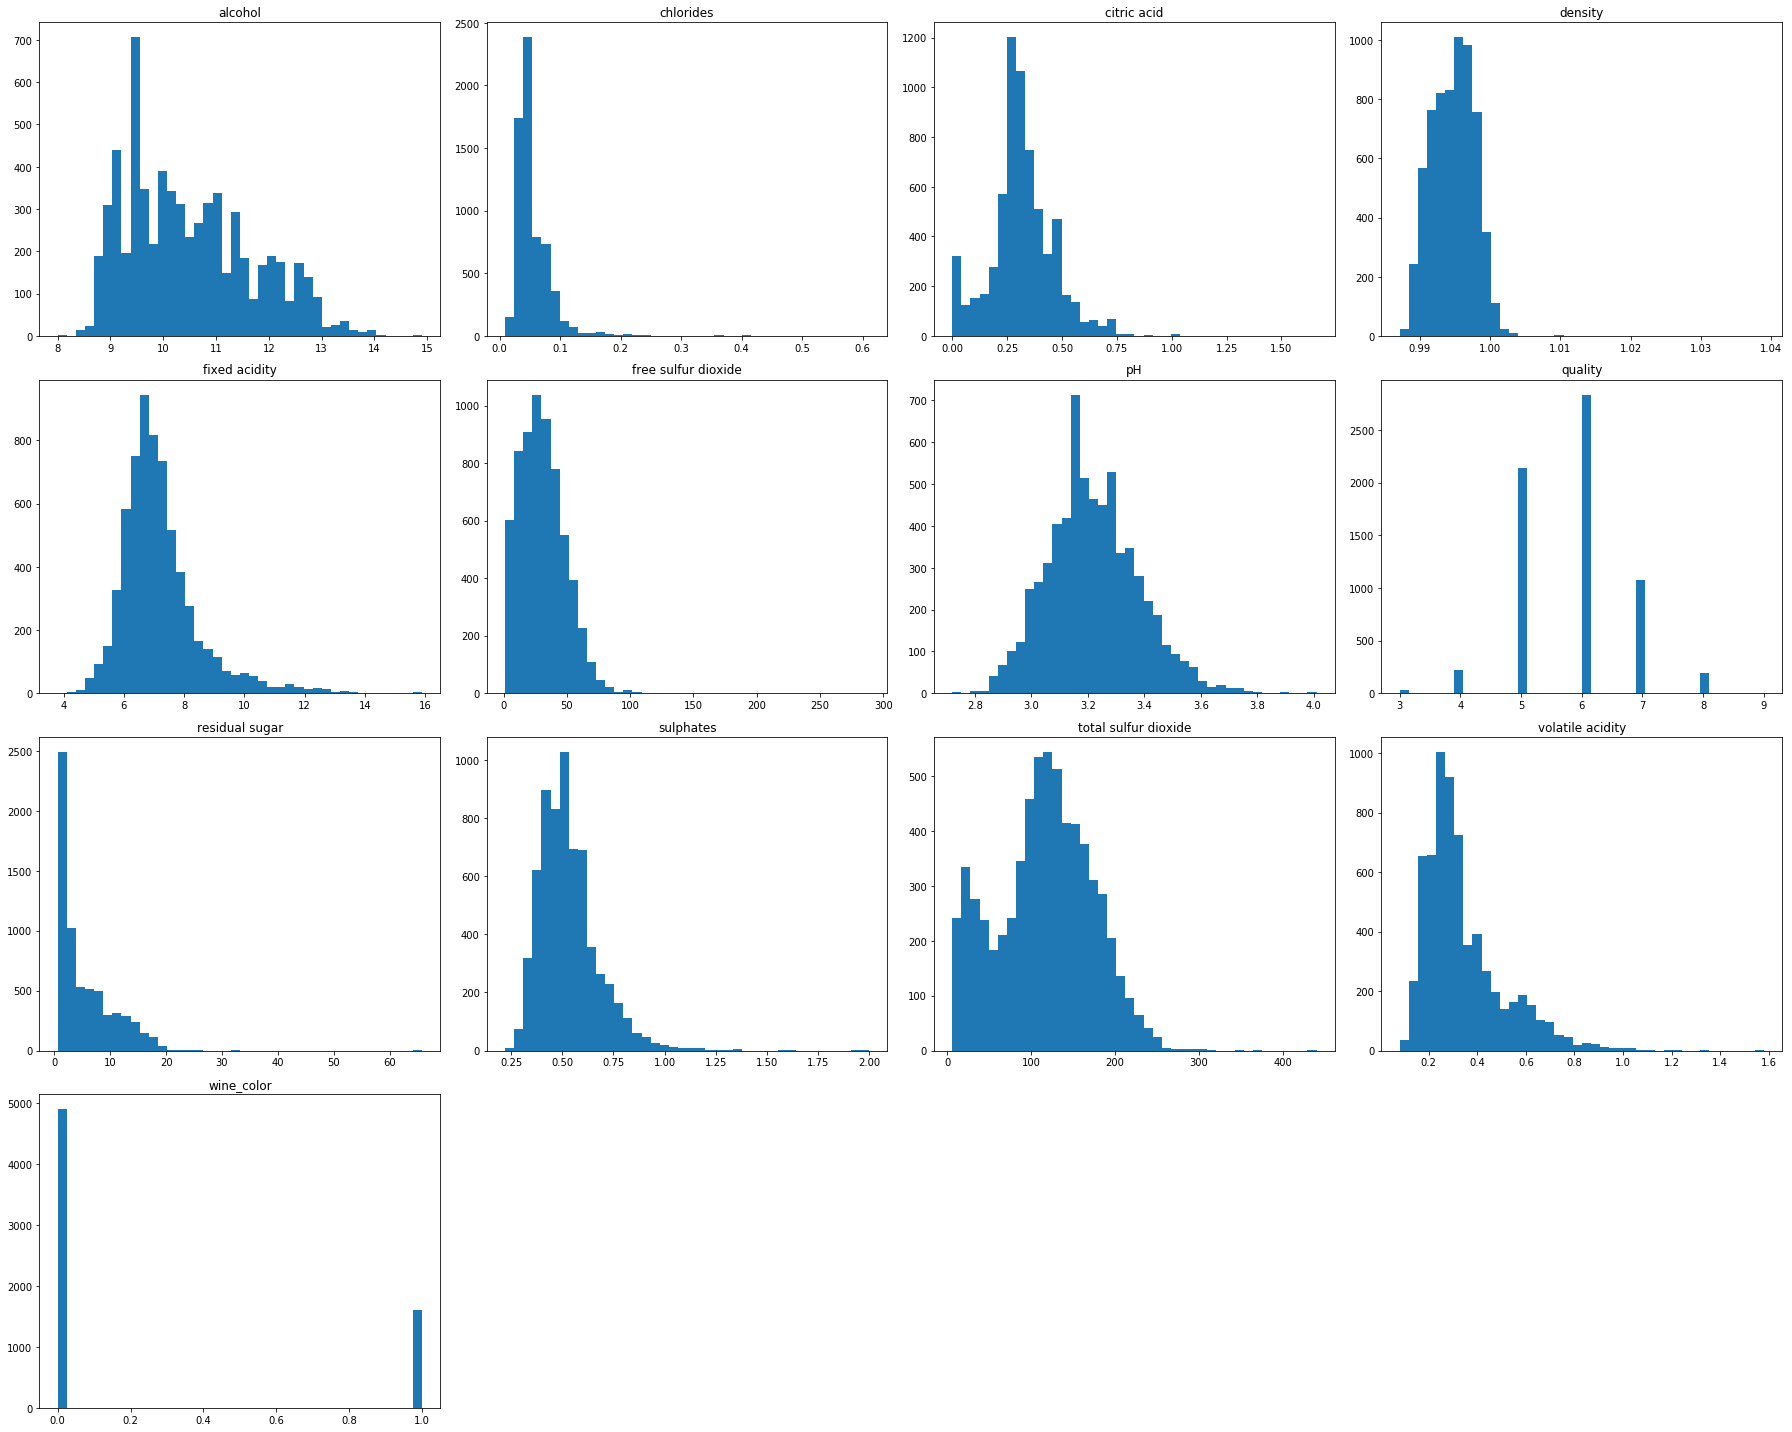

In [35]:
# your code here

# visualize histograms
wine_data.hist(bins=40, grid=False, figsize=(25,20))    
plt.tight_layout()

#### **2.2** Use pandas' `scatter_matrix`  to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [Be aware that this may take quite some time to run.]

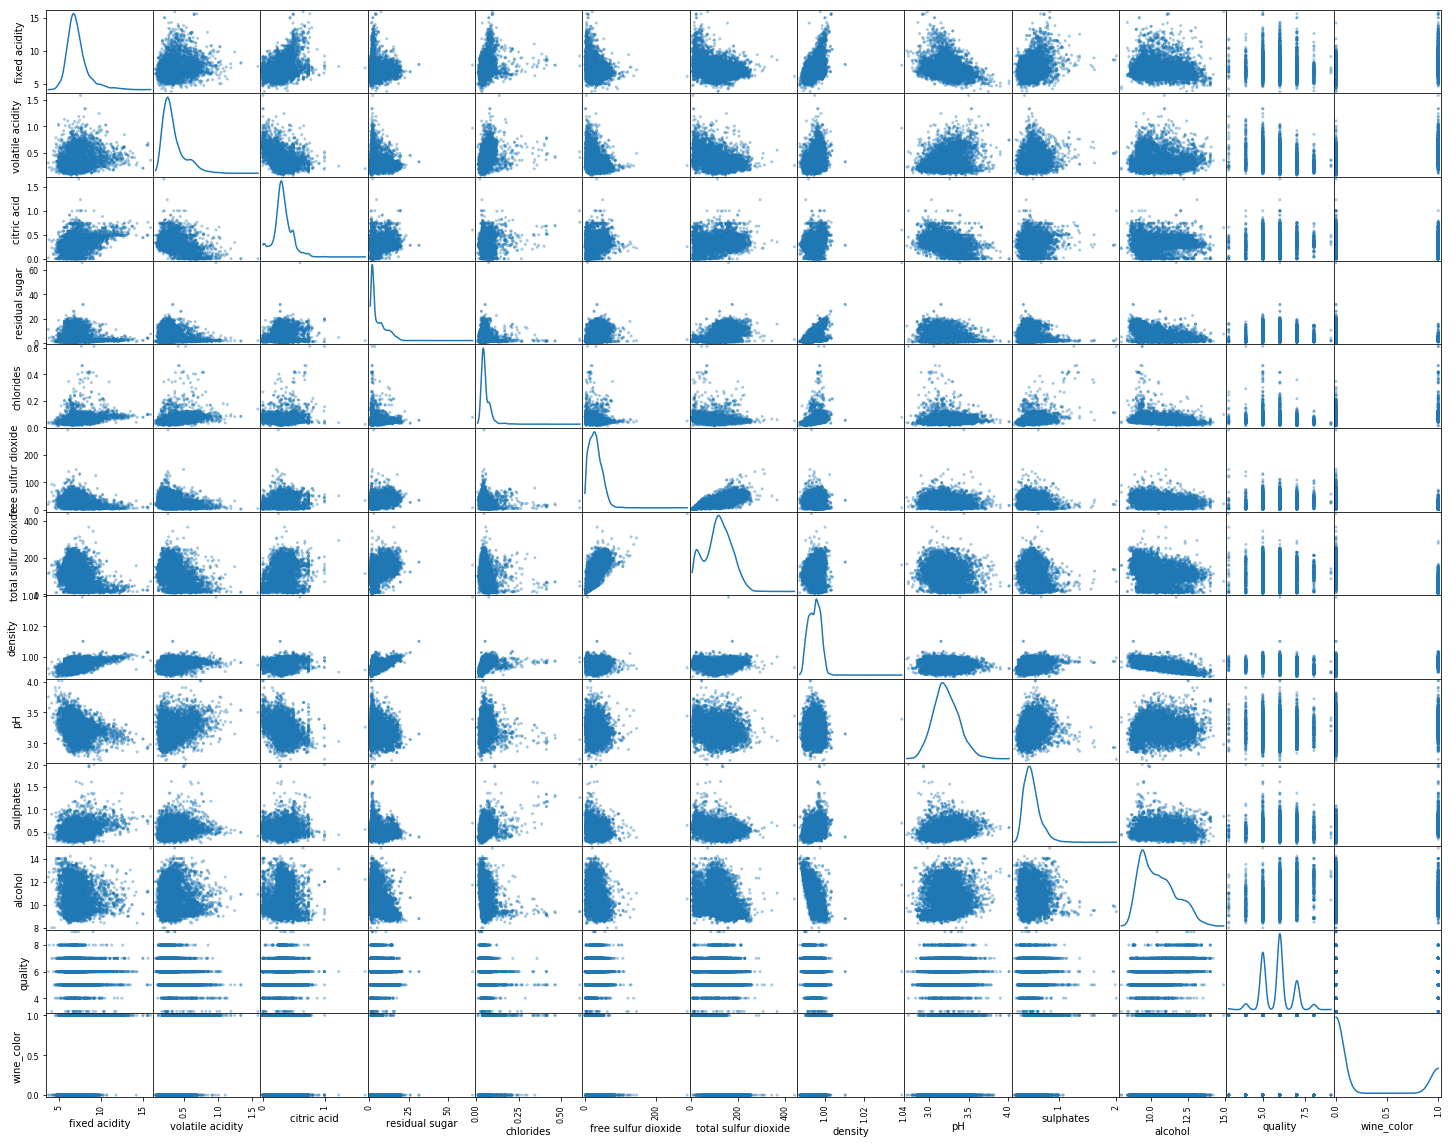

In [13]:
# your code here

# make combinations of features
scatter_matrix(wine_data, alpha=0.4, figsize=(25,20), diagonal='kde');


#### **2.3** Explore in more detail potential correlations amongst the different features by leveraging a pair-wise correlation matrix and depicting it as a heatmap.  What are some features have relatively high positive or negative correlations?

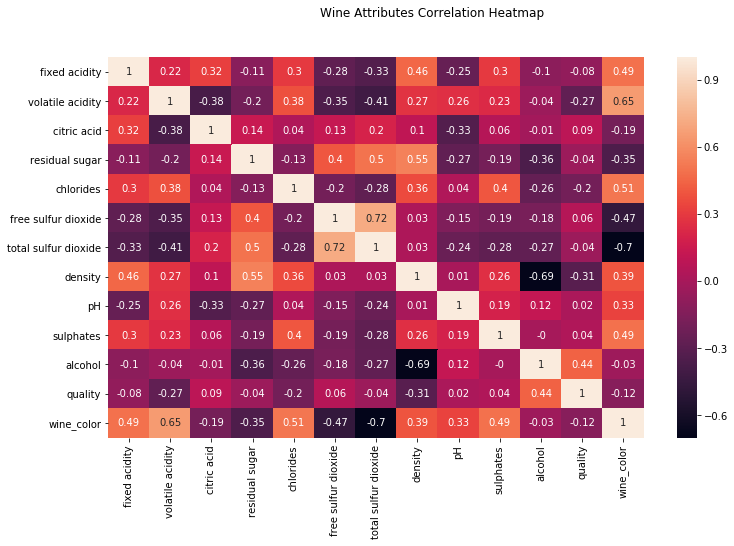

In [40]:
# your code here

f, ax = plt.subplots(figsize=(12, 7))
wine_corr = wine_data.corr()
sns.heatmap(round(wine_corr,2), annot=True, ax=ax)
plt.suptitle('Wine Attributes Correlation Heatmap');

#### **2.4** We merged the datasets for white and red wines.  It may be instructive to determine how the two wine types differ along various features.  Plot side-by-side distributions of the red and white wines for wine quality.  What does your visualization say about how the two types of wine differ?

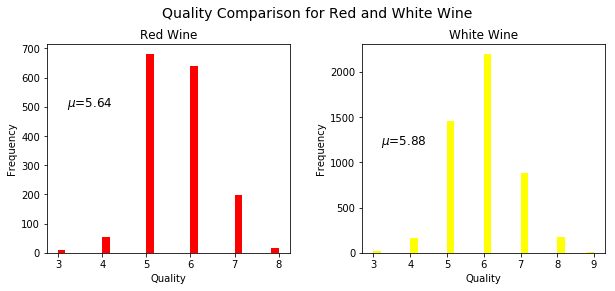

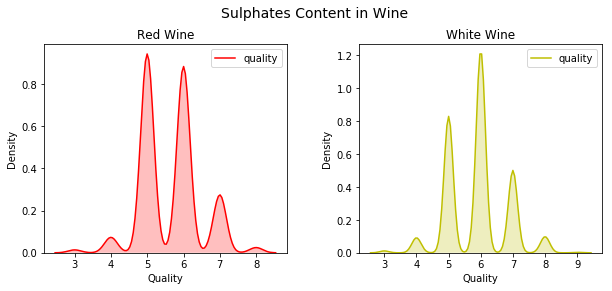

In [82]:
# your code here

# facets with histograms
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Quality Comparison for Red and White Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Frequency") 
ax1.text(3.2, 500, r'$\mu$='+str(round(wine_data[wine_data['wine_color'] == 1]['quality'].mean(),2)), fontsize=12)
ax1.hist(wine_data[wine_data['wine_color'] == 1]['quality'], color='red', bins=30)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Frequency")
ax2.text(3.2, 1200, r'$\mu$='+str(round(wine_data[wine_data['wine_color'] == 0]['quality'].mean(),2)), fontsize=12)
ax2.hist(wine_data[wine_data['wine_color'] == 0]['quality'], color='yellow', bins=30)


# facets with density plots
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("Sulphates Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Quality")
ax1.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['wine_color'] == 1]['quality'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Quality")
ax2.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['wine_color'] == 0]['quality'], ax=ax2, shade=True, color='y');

#### **2.5** Repeat your visualization from **2.4** for another feature you'd expect the two types of wines to differ based on your correlation plot in **2.3**. 

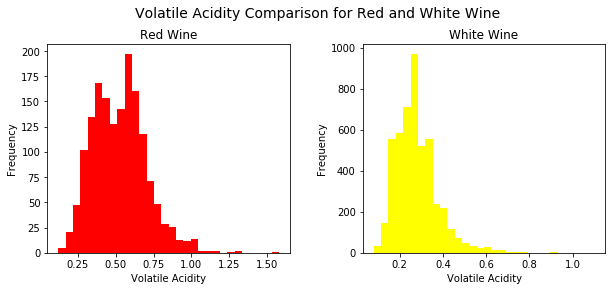

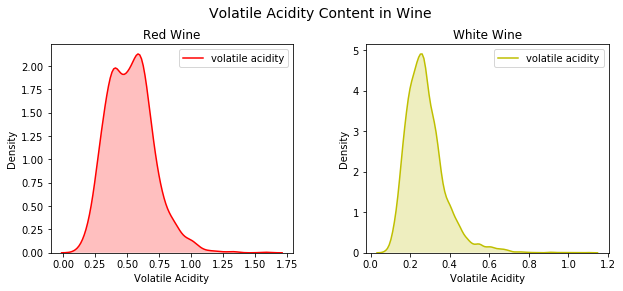

In [83]:
# your code here

# facets with histograms
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Volatile Acidity Comparison for Red and White Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Volatile Acidity")
ax1.set_ylabel("Frequency")
ax1.hist(wine_data[wine_data['wine_color'] == 1]['volatile acidity'], color='red', bins=30)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Volatile Acidity")
ax2.set_ylabel("Frequency")
ax2.hist(wine_data[wine_data['wine_color'] == 0]['volatile acidity'], color='yellow', bins=30)


# facets with density plots
fig = plt.figure(figsize = (10, 4))
title = fig.suptitle("Volatile Acidity Content in Wine", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Red Wine")
ax1.set_xlabel("Volatile Acidity")
ax1.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['wine_color'] == 1]['volatile acidity'], ax=ax1, shade=True, color='r')

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("White Wine")
ax2.set_xlabel("Volatile Acidity")
ax2.set_ylabel("Density") 
sns.kdeplot(wine_data[wine_data['wine_color'] == 0]['volatile acidity'], ax=ax2, shade=True, color='y');

<div class='exercise'> <b> Question 3 [20pts]: Multiple Linear Regression </b> </div>

**3.1** Use `sklearn` to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `quality`.  Show the regression coefficients.

**3.2** Report the $R^2$ score for your multiple linear regression model on the training and test sets.

**3.3** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05).

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?


### Answers

#### **3.1** Use `sklearn` to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `quality`.  Show the regression coefficients.

In [87]:
# your code here

# multiple linear regression
ols_regressor = LinearRegression()
ols_regressor.fit(X_train, y_train)

# displaying coefficients of each feature
ols_coefficients = pd.DataFrame(ols_regressor.coef_, X.columns) 
ols_coefficients.columns = ['Coeffecient'] 

ols_coefficients

,Coeffecient
fixed acidity,0.074922
volatile acidity,-1.562251
citric acid,-0.072093
residual sugar,0.061333
chlorides,-0.783227
free sulfur dioxide,0.004595
total sulfur dioxide,-0.001346
density,-100.356657
pH,0.498345
sulphates,0.703697


#### **3.2** Report the $R^2$ score for your multiple linear regression model on the training and test sets.

In [101]:
# your code here

ols_train_pred = ols_regressor.predict(X_train)
ols_test_pred = ols_regressor.predict(X_test) 

# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(r2_score(y_train, ols_train_pred)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, ols_test_pred)))

Train R^2 = 0.2998
Test R^2 = 0.2825


#### **3.3** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05).

The proper way to solve this problem is to bootstrap in order to generate an ensemble of models and from those models find all coefficients for which 0 is not in the 95% confidence interval.  We're going to cheat and use statsmodels (which just gives us the answer).

In [96]:
# your code here

sm_ols_model = OLS(y_train, sm.add_constant(X_train))
sm_ols_results = sm_ols_model.fit()

sm_ols_results.summary()

/home/igodo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     184.9
Date:                Wed, 19 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:21:42   Log-Likelihood:                -5742.7
No. Observations:                5197   AIC:                         1.151e+04
Df Residuals:                    5184   BIC:                         1.160e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  100.9825     15.421      6.548      0.000      70.750     131.215
fixed acidity            0.0749      0.017      4.329      0.000       0.041       0.109
volatile acidity        -1.5623      0.090    -17.274      0.000      -1.740      -1.385
citric acid             -0.0721      0.090     -0.798      0.425      -0.249       0.105
residual sugar           0.0613      0.007      9.333      0.000       0.048       0.074
chlorides               -0.7832      0.371     -2.108      0.035      -1.511      -0.055
free sulfur dioxide      0.0046      0.001      5.409      0.000       0.003       0.006
total sulfur dioxide    -0.0013      0.000     -3.735      0.000      -0.002      -0.001
density               -100.3567     15.673     -6.403      0.000    -131.081     -69.632
pH                       0.4983      0.099      5.012      0.000       0.303       0.693
sulphates                0.7037      0.083      8.436      0.000       0.540       0.867
alcohol                  0.2219      0.020     11.189      0.000       0.183       0.261
wine_color               0.3742      0.063      5.947      0.000       0.251       0.498
==============================================================================
Omnibus:                      117.376   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              262.767
Skew:                           0.038   Prob(JB):                     8.73e-58
Kurtosis:                       4.099   Cond. No.                     2.89e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
# your code here
sm_ols_results.params[(sm_ols_results.pvalues < 0.005) ]

const                   100.982545
fixed acidity             0.074922
volatile acidity         -1.562251
residual sugar            0.061333
free sulfur dioxide       0.004595
total sulfur dioxide     -0.001346
density                -100.356657
pH                        0.498345
sulphates                 0.703697
alcohol                   0.221928
wine_color                0.374196
dtype: float64

In [98]:
sm_ols_results.params[(sm_ols_results.pvalues >= 0.005)]

citric acid   -0.072093
chlorides     -0.783227
dtype: float64

*your answer here*

All the coefficients are statistically significant except for citric acid and chlorides (according to the sm OLS model)

#### **3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

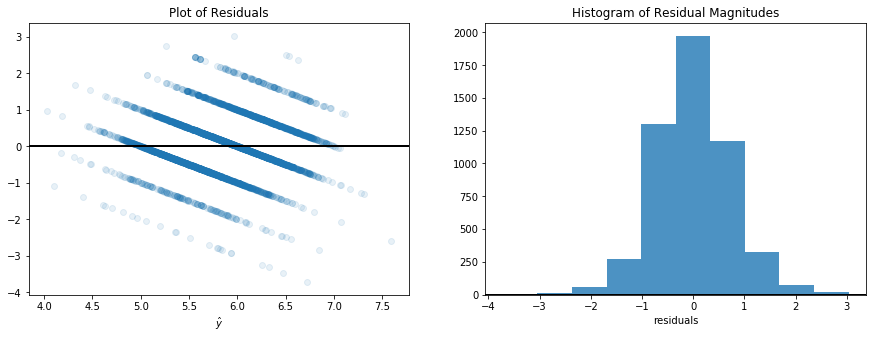

In [102]:
# your code here
residuals = y_train - ols_train_pred
fig, axes = plt.subplots(1,2,figsize=(15,5))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(ols_train_pred, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')

axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

*your answer here* 

We see that linear regression is a poor model for this data.  In the residual scatterplot on the left there is also a pattern to the residuals (not uniform around zero) suggesting there is more than linear behavior needing to be modeled

The residual histogram on the right shows the a pretty symmetric nature of the residuals' distribution.  Th is consistent with normally distributed error (which is an assumption of the model).

<div class='exercise'><b> Question 4 [20pts]: K-Nearest Neighbor Regression </b> </div>

Let's use a different type of regression model -- K-Nearest Neighbor Regression -- and see how well that fits the data.


**4.1** Use 5-fold cross validation to find the best `n_neighbors` parameter for the `sklearn KNeighborRegressor`.  Select `n_neighbors` from {1, 10, 75, 250, 500, 750, 1000}.  Plot the $R^2$ score vs the number of neighbors.  Which `n_neighbors` was the best value?

**4.2** Fit your chosen model from **4.1** to the training data. Report the $R^2$ score for your K-Nearest Neighbor model on the training and test sets.


### Answers

#### **4.1** Use 5-fold cross validation to find the best `n_neighbors` parameter for the `sklearn KNeighborRegressor`.  Select `n_neighbors` from {1, 10, 75, 250, 500, 750, 1000}.  Plot the $R^2$ score vs the number of neighbors.  Which `n_neighbors` was the best value?

In [122]:
# your code here

knn_gs_params = {'n_neighbors': [1, 5, 10, 15, 25, 50, 75]}

knn_model_gs = GridSearchCV(KNeighborsRegressor(), knn_gs_params, cv=5, scoring='r2', return_train_score=True)

knn_model_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 5, 10, 15, 25, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [131]:
knn_model_gs.best_params_

{'n_neighbors': 15}

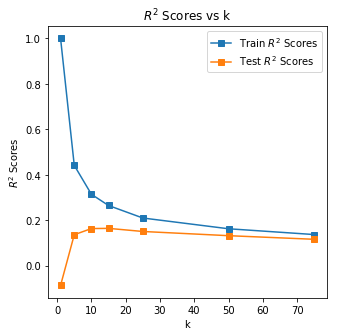

In [123]:
knn_gs_results = pd.DataFrame(knn_model_gs.cv_results_)

fig, axes = plt.subplots(figsize = (5,5))
axes.plot(knn_gs_results['param_n_neighbors'], knn_gs_results['mean_train_score'], 's-', label='Train $R^2$ Scores')
axes.plot(knn_gs_results['param_n_neighbors'], knn_gs_results['mean_test_score'], 's-', label='Test $R^2$ Scores')
axes.set_xlabel('k')
axes.set_ylabel('$R^2$ Scores')
# A generic title of this format (y vs x) is generally appropriate
axes.set_title("$R^2$ Scores vs k")
# Including a legend is very important
axes.legend();

Setting number of neighbors equal to 15 gives the best results.

#### **4.2** Fit your chosen model from **4.1** to the training data. Report the $R^2$ score for your K-Nearest Neighbor model on the training and test sets.
 

In [129]:
knn_model_best = KNeighborsRegressor(n_neighbors=15)

knn_model_best.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')

In [130]:
# your code here

knn_train_pred = knn_model_best.predict(X_train)
knn_test_pred = knn_model_best.predict(X_test) 

# calculating and reporting the requested values, particularly the Test R^2
print('Train R^2 = {:.4}'.format(r2_score(y_train, knn_train_pred)))
print('Test R^2 = {:.4}'.format(r2_score(y_test, knn_test_pred)))

Train R^2 = 0.2772
Test R^2 = 0.1574


<div class='exercise'><b> Question 5 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**5.1** Use `sklearn` to fit multiple linear regression models with regularization  to the training set using all the predictors (no interactions or polynomial terms) to predict `quality`.  Make sure to fit a Ridge model and a Lasso model. Use `RidgeCV` and `LassoCV` with 5-fold cross-validation to select the best regularization level from among `(.1,.5,1,5,10,50,100)`.  Show the coefficients for each model.

**5.2** What are the $R^2$ scores for Lasso, Ridge, and OLS?  How do they compare?

**5.3** Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.4** What trends do you see in the plot above?

### Answers

#### **5.1** Use `sklearn` to fit multiple linear regression models with regularization  to the training set using all the predictors (no interactions or polynomial terms) to predict `quality`.  Make sure to fit a Ridge model and a Lasso model. Use `RidgeCV` and `LassoCV` with 5-fold cross-validation to select the best regularization level from among `(.1,.5,1,5,10,50,100)`.  Show the coefficients for each model.

In [133]:
#your code here
alphas = (.1,.5,1,5,10,50,100)

ridge_regressor = RidgeCV(cv=5, alphas=alphas).fit(X_train, y_train)
lasso_regressor = LassoCV(cv=5, alphas=alphas).fit(X_train, y_train)

In [149]:
# displaying coefficients of each feature
ols_coefficients = pd.DataFrame(ols_regressor.coef_, X.columns) 
ols_coefficients.columns = ['OLS Coefficient'] 

ols_coefficients

,Coeffecient
fixed acidity,0.074922
volatile acidity,-1.562251
citric acid,-0.072093
residual sugar,0.061333
chlorides,-0.783227
free sulfur dioxide,0.004595
total sulfur dioxide,-0.001346
density,-100.356657
pH,0.498345
sulphates,0.703697


In [151]:
# displaying coefficients of each feature
ridge_coefficients = pd.DataFrame(ridge_regressor.coef_, X.columns) 
ridge_coefficients.columns = ['Ridge Coefficient'] 

ridge_coefficients

,Ridge Coefficient
fixed acidity,-0.006338
volatile acidity,-1.627489
citric acid,-0.107767
residual sugar,0.023578
chlorides,-0.980247
free sulfur dioxide,0.005187
total sulfur dioxide,-0.001657
density,-2.141628
pH,0.121278
sulphates,0.575418


In [152]:
# displaying coefficients of each feature
lasso_coefficients = pd.DataFrame(lasso_regressor.coef_, X.columns) 
lasso_coefficients.columns = ['Lasso Coefficient'] 

lasso_coefficients

,Lasso Coefficient
fixed acidity,-0.000000
volatile acidity,-0.000000
citric acid,0.000000
residual sugar,0.008834
chlorides,-0.000000
free sulfur dioxide,0.006919
total sulfur dioxide,-0.000954
density,-0.000000
pH,-0.000000
sulphates,0.000000


#### **5.2** What are the $R^2$ scores for Lasso, Ridge, and OLS?  How do they compare?

In [153]:
# your code here

ols_train_pred = ols_regressor.predict(X_train)
ols_test_pred = ols_regressor.predict(X_test) 

ridge_train_pred = ridge_regressor.predict(X_train)
ridge_test_pred = ridge_regressor.predict(X_test)

lasso_train_pred = lasso_regressor.predict(X_train)
lasso_test_pred = lasso_regressor.predict(X_test) 

# calculating and reporting the requested values, particularly the Test R^2
print('OLS Train R^2 = {:.4}'.format(r2_score(y_train, ols_train_pred)))
print('OLS Test R^2 = {:.4}'.format(r2_score(y_test, ols_test_pred)))

print('Ridge Train R^2 = {:.4}'.format(r2_score(y_train, ridge_train_pred)))
print('Ridge Test R^2 = {:.4}'.format(r2_score(y_test, ridge_test_pred)))

print('Lasso Train R^2 = {:.4}'.format(r2_score(y_train, lasso_train_pred)))
print('Lasso Test R^2 = {:.4}'.format(r2_score(y_test, lasso_test_pred)))

OLS Train R^2 = 0.2998
OLS Test R^2 = 0.2825
Ridge Train R^2 = 0.2944
Ridge Test R^2 = 0.2764
Lasso Train R^2 = 0.2117
Lasso Test R^2 = 0.2171


Ridge and OLS models are pretty comparable, but Lasso model performs a bit worse than the other two models.

#### **5.3** Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

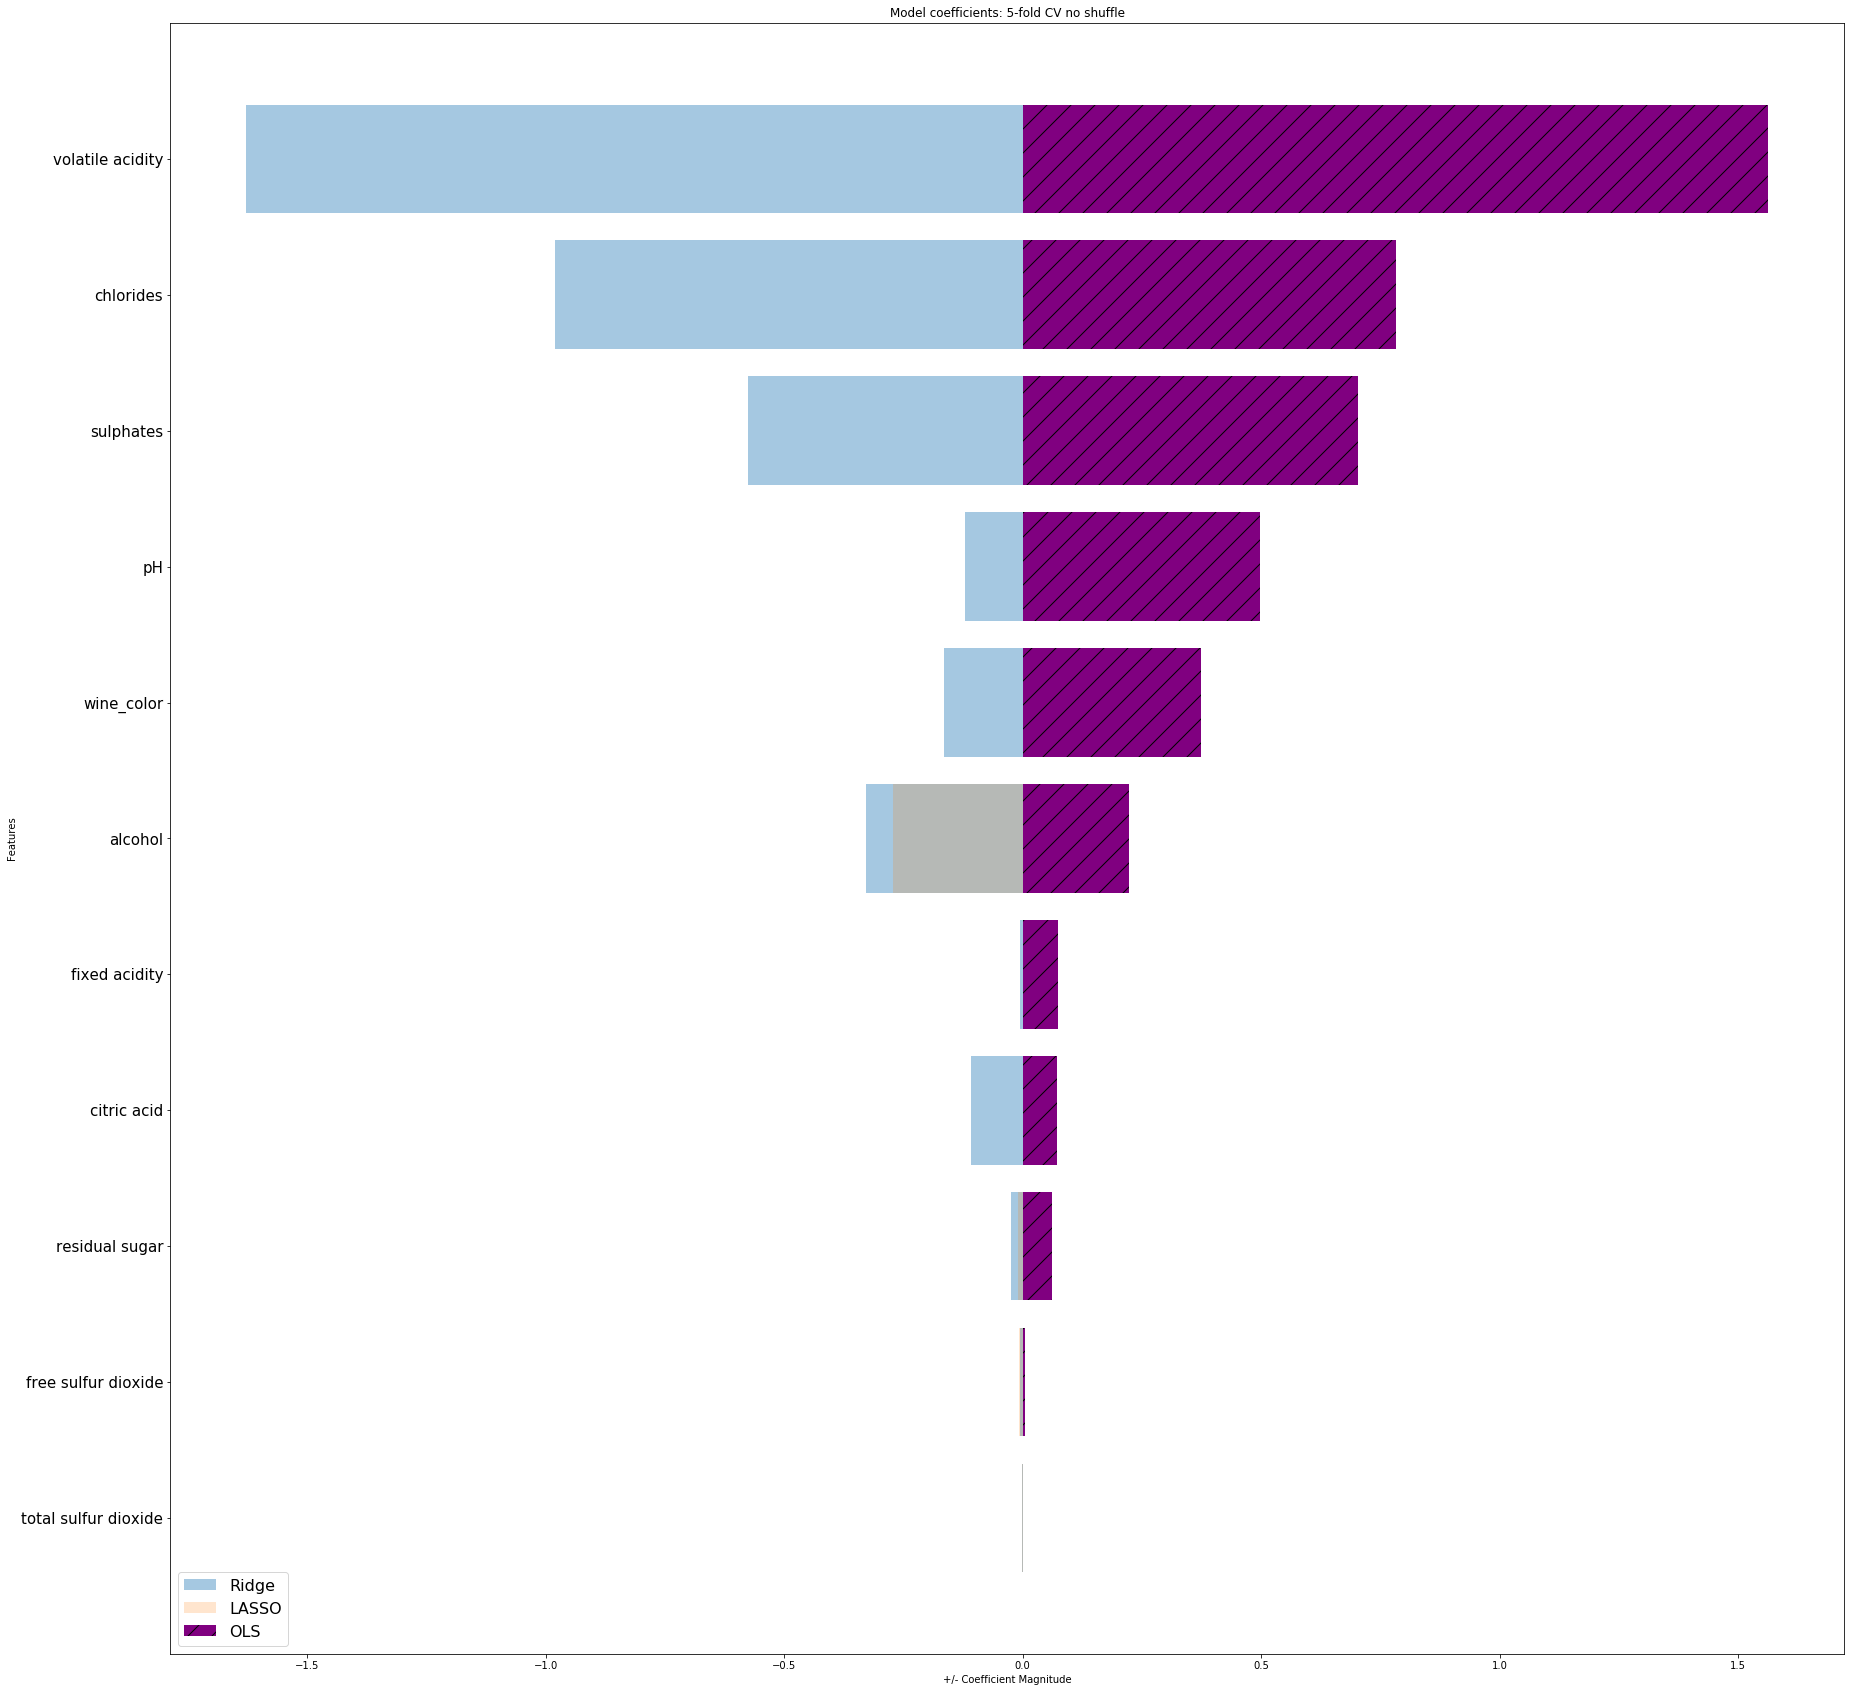

In [147]:
# your code here
feature_names = X_train.columns.values

Ridge_coefficients = ridge_regressor.coef_
Lasso_coefficients = lasso_regressor.coef_
OLS_coefficients = ols_regressor.coef_

si= np.argsort(np.abs(ols_regressor.coef_))[:-1]
feature_names = X_train.columns.values[si]
n_coeffs = len(feature_names)

plt.figure(figsize=(30,30))
plt.barh(np.arange(n_coeffs), 
         -np.abs(Ridge_coefficients)[si], 
         alpha=0.4, label='Ridge')

plt.barh(np.arange(n_coeffs), 
         -np.abs(Lasso_coefficients)[si], 
         alpha=0.2, label='LASSO')
plt.barh(np.arange(n_coeffs), 
         np.abs(OLS_coefficients)[si], 
         color='purple', hatch='/', label='OLS')

plt.yticks(range(n_coeffs), feature_names, rotation=0, fontsize=15)
plt.ylim(-1,n_coeffs)
#plt.xlim(-100,300)

plt.legend(fontsize=16)

plt.title("Model coefficients: 5-fold CV no shuffle")
plt.ylabel("Features")
plt.xlabel("+/- Coefficient Magnitude");

#### **5.4** What trends do you see in the plot above?

Many of the variables have been reduced to zero for Lasso, where as Ridge has shrunk the coefficients. 

<div class='exercise'><b> Question 6 [20pts]: Polynomial Features </b> </div>

**6.1** Augment your training set by using the continuous features from `X_train` -- that is all the features except for `wine_color` to generate up to the fourth degree polynomial features (including interaction terms) and adding them to the datasets.  Call this new dataset  `X_train_poly`.

**6.2** Repeat the process in **5.1** to create a test set `X_test_poly` also augmented with polynomial features up to the fourth degree.

**6.3** Use `sklearn` to fit multiple linear regression models with and withoutregularization to the augmented training set with polynomial feautres to predict `quality`.  Make sure to fit a simple OLS model, a Ridge model and a Lasso model. Use `RidgeCV` and `LassoCV` with 5-fold cross-validation to select the best regularization level from among `(.1,.5,1,5,10,50,100)`.  Show the coefficients for each model.

Note: On the lasso model, you may need to increase `max_iter` to 100,000 for the optimization to converge.

**6.4** What are the training and test set $R^2$ scores for Lasso, Ridge, and OLS on the augmented data sets?  How do they compare to your earlier models on the original data set?

**6.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**6.6** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial?

### Answers

#### **6.1** Augment your training set by using the continuous features from `X_train` -- that is all the features except for `wine_color` to generate up to the fourth degree polynomial features (including interaction terms) and adding them to the datasets.  Call this new dataset  `X_train_poly`.

In [178]:
X_continuous_columns = X_train.drop('wine_color', axis=1).columns

poly = PolynomialFeatures(degree=4, include_bias=False)

X_train_poly = pd.concat([pd.DataFrame(poly.fit_transform(X_train[X_continuous_columns]), columns=poly.get_feature_names(X_continuous_columns), index=X_train.index),X_train[['wine_color']]], axis=1)

#### **6.2** Repeat the process in **5.1** to create a test set `X_test_poly` also augmented with polynomial features up to the fourth degree.

In [179]:
poly = PolynomialFeatures(degree=4, include_bias=False)

X_test_poly = pd.concat([pd.DataFrame(poly.fit_transform(X_test[X_continuous_columns]), columns=poly.get_feature_names(X_continuous_columns), index=X_test.index),X_test[['wine_color']]], axis=1)

#### **6.2** Repeat the process in **5.1** to create a test set `X_test_poly` also augmented with polynomial features up to the fourth degree.

In [179]:
poly = PolynomialFeatures(degree=4, include_bias=False)

X_test_poly = pd.concat([pd.DataFrame(poly.fit_transform(X_test[X_continuous_columns]), columns=poly.get_feature_names(X_continuous_columns), index=X_test.index),X_test[['wine_color']]], axis=1)

#### **6.3**  Use `sklearn` to fit multiple linear regression models with and withoutregularization to the augmented training set with polynomial feautres to predict `quality`.  Make sure to fit a simple OLS model, a Ridge model and a Lasso model. Use `RidgeCV` and `LassoCV` with 5-fold cross-validation to select the best regularization level from among `(.1,.5,1,5,10,50,100)`.  Show the coefficients for each model.

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.


In [181]:
#your code here
alphas = (.1,.5,1,5,10,50,100)

ols_regressor_poly = LinearRegression().fit(X_train_poly, y_train)
ridge_regressor_poly = RidgeCV(cv=5, alphas=alphas).fit(X_train_poly, y_train)
lasso_regressor_poly = LassoCV(cv=5, alphas=alphas, max_iter=100000).fit(X_train_poly, y_train)

/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.80913e-24): result may not be accurate.
  overwrite_a=True).T
/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=7.92447e-24): result may not be accurate.
  overwrite_a=True).T
/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.46514e-24): result may not be accurate.
  overwrite_a=True).T
/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.44436e-24): result may not be accurate.
  overwrite_a=True).T
/home/igodo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.57034e-24): result may not be accurate.
  overwrite_a=True).T
/home/igodo/anaconda3/lib/pyth

In [183]:
# displaying coefficients of each feature
ols_coefficients_poly = pd.DataFrame(ols_regressor_poly.coef_, X_train_poly.columns) 
ols_coefficients_poly.columns = ['OLS Coefficient'] 

ols_coefficients_poly

,OLS Coefficient
fixed acidity,185.840478
volatile acidity,-9658.642184
citric acid,-12193.118286
residual sugar,1215.697217
chlorides,-8999.706869
free sulfur dioxide,4734.526926
total sulfur dioxide,1742.991042
density,8973.018772
pH,-15676.125135
sulphates,3134.640503


In [184]:
# displaying coefficients of each feature
ridge_coefficients_poly = pd.DataFrame(ridge_regressor_poly.coef_, X_train_poly.columns) 
ridge_coefficients_poly.columns = ['Ridge Coefficient'] 

ridge_coefficients_poly

,Ridge Coefficient
fixed acidity,-0.003031
volatile acidity,-0.001113
citric acid,-0.000924
residual sugar,0.008378
chlorides,0.000298
free sulfur dioxide,0.001867
total sulfur dioxide,-0.011418
density,-0.000043
pH,0.002402
sulphates,-0.000565


In [185]:
# displaying coefficients of each feature
lasso_coefficients_poly = pd.DataFrame(lasso_regressor_poly.coef_, X_train_poly.columns) 
lasso_coefficients_poly.columns = ['Lasso Coefficient'] 

lasso_coefficients_poly

,Lasso Coefficient
fixed acidity,0.000000
volatile acidity,-0.000000
citric acid,0.000000
residual sugar,0.000000
chlorides,-0.000000
free sulfur dioxide,0.000000
total sulfur dioxide,-0.000000
density,-0.000000
pH,-0.000000
sulphates,0.000000


#### **6.4** What are the training and test set $R^2$ scores for Lasso, Ridge, and OLS on the augmented data sets?  How do they compare to your earlier models on the original data set?


In [186]:
# your code here

ols_train_pred_poly = ols_regressor_poly.predict(X_train_poly)
ols_test_pred_poly = ols_regressor_poly.predict(X_test_poly) 

ridge_train_pred_poly = ridge_regressor_poly.predict(X_train_poly)
ridge_test_pred_poly = ridge_regressor_poly.predict(X_test_poly)

lasso_train_pred_poly = lasso_regressor_poly.predict(X_train_poly)
lasso_test_pred_poly = lasso_regressor_poly.predict(X_test_poly) 

# calculating and reporting the requested values, particularly the Test R^2
print('OLS Train R^2 = {:.4}'.format(r2_score(y_train, ols_train_pred_poly)))
print('OLS Test R^2 = {:.4}'.format(r2_score(y_test, ols_test_pred_poly)))

print('Ridge Train R^2 = {:.4}'.format(r2_score(y_train, ridge_train_pred_poly)))
print('Ridge Test R^2 = {:.4}'.format(r2_score(y_test, ridge_test_pred_poly)))

print('Lasso Train R^2 = {:.4}'.format(r2_score(y_train, lasso_train_pred_poly)))
print('Lasso Test R^2 = {:.4}'.format(r2_score(y_test, lasso_test_pred_poly)))

OLS Train R^2 = 0.258
OLS Test R^2 = -18.66
Ridge Train R^2 = 0.5125
Ridge Test R^2 = 0.3045
Lasso Train R^2 = 0.3259
Lasso Test R^2 = 0.3041


Polynomial features were very overfit for OLS, but showed minor improvement for Lasso and Ridge over the non-polynomial features.

#### **6.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

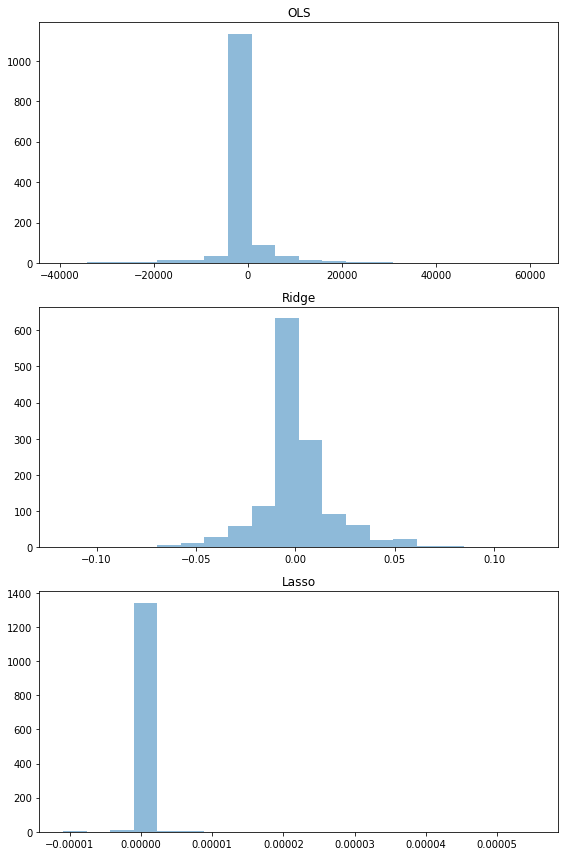

In [190]:
# your code here
alpha_val=0.5

fig, axs = plt.subplots(3, 1, figsize=(8, 12))

axs[0].hist(ols_regressor_poly.coef_, bins=20, alpha=alpha_val)
axs[0].set_title("OLS")

axs[1].hist(ridge_regressor_poly.coef_, bins=20, alpha=alpha_val)
axs[1].set_title("Ridge")

axs[2].hist(lasso_regressor_poly.coef_, bins=20, alpha=alpha_val)
axs[2].set_title("Lasso")
plt.tight_layout()

Lasso and Ridge showed significant shrinkage with Lasso eliminating a number of features.

**6.6** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

*your answer here*


One major advantage of lasso over ridge is that it produces simpler and more interpretable models that involve only a subset of the predictors.  Lasso indirectly performs variable selection as it shrinks coefficients down to zero. 

Ridge regression’s advantage over least squares is rooted in the bias-variance trade-off. As $\lambda$ increases, the flexibility of the ridge regression fit decreases, leading to decreased variance but increased bias. Ridge regression works best in situations where the least squares estimates have high variance.

Ridge uses L2 penalty, whereas Lasso uses L1 penalty. 

Higher degreee of polynomial will overfit to training data, resulting in poor fit to test data. 

Source: ISLR Book

---